##### Partners:
##### Bo Zhang
##### Xuanyu Wu
##### Haoming Zhang

## Reading Data; Data Prep.

In [444]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
import re

In [2]:
os.listdir()

['sample.reviews.json',
 'GOOGLE LOCAL.ipynb',
 'reviews.clean.json',
 'users.clean.json',
 '.ipynb_checkpoints',
 'places.clean.json']

In [11]:
def parseData(fname):
    data = []
    with open(fname,'rb') as f:
        for l in f.readlines():
            data.append(eval(l))
    return data

In [18]:
reviews = []
with open('sample.reviews.json') as f:
    reviews = json.load(f)

In [20]:
review_df = pd.DataFrame(reviews)

In [21]:
user = parseData('users.clean.json')

In [22]:
user_df = pd.DataFrame(user)

In [23]:
places = parseData('places.clean.json')

In [24]:
places_df = pd.DataFrame(places)

##### We notice that more than 90% of the reviews have unique ids, which means that a lot of those users are 
##### inactive users, which is meaningless to analyze, thus we clean the data by ensuring that the each user and place
##### have more than 3 comments.

In [44]:
# Select Active User
user_count = review_df['gPlusUserId'].value_counts()
active_user_id = user_count.where(user_count >3).dropna().index
# Select Active Places
place_count = review_df['gPlusPlaceId'].value_counts()
active_place_id = place_count.where(place_count >3).dropna().index

In [ ]:
## Valid User df and valid place df are those with active ids with active reviews

In [26]:
valid_user_df = user_df[user_df['gPlusUserId'].isin(active_user_id)]


In [295]:
valid_place_df = places_df[places_df['gPlusPlaceId'].isin(active_place_id)]

In [ ]:
## select reviews with both user and places being active

In [27]:
valid_review_df = review_df[review_df['gPlusUserId'].isin(active_user_id) & review_df['gPlusPlaceId'].isin(active_place_id)]

In [30]:
valid_review_df.shape

(5801, 8)

In [ ]:
## Drop those not inside user_df and places_df

In [34]:
valid_review_df_dropped = valid_review_df[valid_review_df['gPlusUserId'].isin(user_df['gPlusUserId']) & \
                                          valid_review_df['gPlusPlaceId'].isin(places_df['gPlusPlaceId'])]

In [47]:
valid_user_df.shape

(5929, 6)

In [296]:
valid_place_df.shape

(7298, 8)

In [49]:
valid_review_df_dropped.shape

(4461, 8)

# Task

#### Task: We focus on predict the rating given a pair of random user and place.

#### Business Insight: If we can predict how likely a user would like a random place based on user's activities history and the characteristic of the place, we can recommend the places to users by ranking the ratings of places around them. 

## BaseLine Model

#### BaseLine Model: we predict the rating by the mean of average rating of the user and the average rating of the place with equal weights.

In [50]:
from sklearn.utils import shuffle
df = shuffle(valid_review_df_dropped)
size = len(df)
train_data = df[:int(size * 0.8)]
validate_data = df[int(size * 0.8): int(size * 0.9)]
test_data = df[int(size * 0.9):]

In [51]:
user_rating_avg = train_data.groupby('gPlusUserId')['rating'].mean().to_dict()
place_rating_avg = train_data.groupby('gPlusPlaceId')['rating'].mean().to_dict()
total_avg = train_data['rating'].mean()

In [52]:
def predict(row):
    hasUser = row['gPlusUserId'] in user_rating_avg.keys()
    hasPlace = row['gPlusPlaceId'] in place_rating_avg.keys()
    if hasUser and hasPlace:
        return (user_rating_avg[row['gPlusUserId']] + place_rating_avg[row['gPlusPlaceId']]) / 2
    elif hasUser:
        return user_rating_avg[row['gPlusUserId']]
    elif hasPlace:
        return place_rating_avg[row['gPlusPlaceId']]
    else:
        return total_avg
predictions = validate_data.apply(predict, axis = 1)
((validate_data['rating'] - predictions) ** 2).mean()

0.8264152661431119

## Feature Engineering and Feature Augumentation and Data Imputation

## User DataFrame

###### Deal with hours:
###### Here we get opening hours, closing hours, length of opening and days of opening per week from the original "hours" column by feature augmentation.

In [298]:
open_times = []
close_times = []
num_dayss = []

existence = valid_place_df['hours'].isna()

for i in range(len(valid_place_df)):
    
    l = valid_place_df['hours'].iloc[i]
    
    if existence.iloc[i]:
        open_times.append(np.nan)
        close_times.append(np.nan)
        num_dayss.append(np.nan)
        continue
    num_days = len(l)
    
    open_time = []
    close_time = []
    opening_time_lst = [day[1][0][0] for day in l]
    for time in opening_time_lst:
        if '24' in time:
            open_time.append(0)
            close_time.append(24)
            
        if '-' in time:
            open_time_str = time.split('-')[0]
            close_time_str = time.split('-')[2]
            open_time_num = 0
            close_time_num = 0

            if 'am' in open_time_str:
                open_time_num = int(open_time_str[:-6])
            elif 'pm' in open_time_str:
                open_time_num = int(open_time_str[:-6]) + 12
            else:
                continue
            open_time.append(open_time_num)

            if 'am' in close_time_str:
                close_time_num = int(close_time_str[:-6])
            elif 'pm' in close_time_str:
                close_time_num = int(close_time_str[:-6]) + 12
            else:
                continue
            close_time.append(close_time_num)
    avg_open_time = np.mean(open_time)
    open_times.append(avg_open_time)
    avg_close_time = np.mean(close_time)
    close_times.append(avg_close_time)
    num_dayss.append(num_days)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [299]:
valid_place_df['open_times'] = open_times
valid_place_df['close_times'] = close_times
valid_place_df['num_days'] = num_dayss

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

###### deal with price

In [301]:
valid_place_df['price_size'] = valid_place_df['price'].apply(lambda x: 0 if x is None else len(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


###### deal with phone number by checking availablility of phone number

In [303]:
valid_place_df['phone_available'] = 1 - valid_place_df['phone'].isna()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [304]:
valid_place_df['num_hours_opening'] = valid_place_df['close_times'] - valid_place_df['open_times']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


###### Data imputation of filling missing values.

In [305]:
val = valid_place_df['open_times'].loc[valid_place_df['open_times'].notna()].mean()
valid_place_df['open_times'].fillna(val, inplace = True)

In [306]:
val = valid_place_df['close_times'].loc[valid_place_df['close_times'].notna()].mean()
valid_place_df['close_times'].fillna(val, inplace = True)
val = valid_place_df['num_days'].loc[valid_place_df['num_days'].notna()].mean()
valid_place_df['num_days'].fillna(val, inplace = True)
val = valid_place_df['num_hours_opening'].loc[valid_place_df['num_hours_opening'].notna()].mean()
valid_place_df['num_hours_opening'].fillna(val, inplace = True)

In [311]:
val = valid_place_df['price_size'].loc[valid_place_df['price_size'] != 0].mean()

In [313]:
valid_place_df['price_size'].replace(0, val,inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [324]:
cleaned_place_df = valid_place_df

In [325]:
cleaned_place_df.set_index('gPlusPlaceId', inplace=True)

In [326]:
final_place_df = cleaned_place_df[cleaned_place_df.columns[7:]]

In [327]:
val = final_place_df['price_size'].loc[final_place_df['price_size'] != 0].mean()

In [328]:
final_place_df['price_size'] = final_place_df['price_size'].replace(to_replace = 0, value = val)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [332]:
valid_user_df.set_index('gPlusUserId', inplace=True)

In [333]:
merged = valid_review_df_dropped.merge(final_place_df, right_index=True, left_on = 'gPlusPlaceId', how = 'left')

In [334]:
user_interested_cols = ['open_times', 'close_times', 'num_days', 'price_size', 'num_hours_opening']

In [335]:
user_avg_info = merged.groupby('gPlusUserId')[user_interested_cols].mean()

In [337]:
final_user_df = user_avg_info.copy()

In [361]:
words = []
for cat in list(valid_review_df_dropped.categories.values):
    if cat is not None:
        for l in cat:

            for s in l.split():
                if len(re.findall(r'[a-zA-Z]', s)) > 0:
                    words.append(s)
cat_counts = pd.Series(words).value_counts()
common_cat = list(cat_counts.where(cat_counts > 100).dropna().index)

In [362]:
df = valid_review_df_dropped#.dropna(subset = ['categories'])#.loc[valid_review_df_dropped['gPlusUserId'] == '110090296112763745586']
user_rating_cat = {}
for i in range(len(df)):
    row = df.iloc[i]
    if row['gPlusUserId'] not in user_rating_cat.keys():
        user_rating_cat[row['gPlusUserId']] = {}
        for cat in common_cat:
            user_rating_cat[row['gPlusUserId']][cat] = []
        user_rating_cat[row['gPlusUserId']]['Other'] = []
    #if row['gPlusUserId'] in user_rating_cat.keys():
    if row['categories'] is not None:
        for words in row['categories']:
            for w in words.split():
                if w in common_cat:
                    user_rating_cat[row['gPlusUserId']][w].append(row['rating'])
                else:
                    user_rating_cat[row['gPlusUserId']]['Other'].append(row['rating'])

In [364]:
place_dict = {}
for i in range(len(df)):
    row = df.iloc[i]
    place = row['gPlusPlaceId']

    if place not in place_dict.keys():
        place_dict[place] = []
    if row['categories'] is not None:
        for s in row['categories']:
            for w in s.split():
                if w in common_cat:
                    place_dict[place].append(w)
                else:
                    place_dict[place].append('Other')
place_dict = {s:list(set(place_dict[s])) for s in place_dict.keys()}

# Exploratory Data Analysis

count    4461.000000
mean        4.076440
std         0.860041
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64


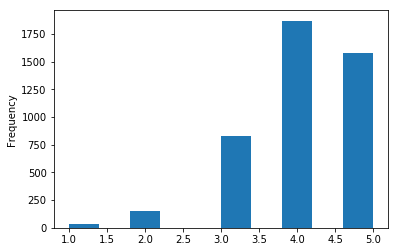

In [475]:
%matplotlib inline
rating = valid_review_df_dropped.rating
print(rating.describe())
rating.plot(kind='hist')

In [476]:
final_place_df.describe()

,open_times,close_times,num_days,price_size,phone_available,num_hours_opening
count,7298.000000,7298.000000,7298.0,7298.000000,7298.000000,7298.000000
mean,9.486074,17.355601,7.0,2.057252,0.950945,7.869528
std,2.955122,4.815404,0.0,0.325923,0.215997,6.730079
min,0.000000,1.000000,7.0,1.000000,0.000000,-23.000000
25%,9.000000,17.355601,7.0,2.057252,1.000000,7.869528
50%,9.486074,17.355601,7.0,2.057252,1.000000,7.869528
75%,10.000000,20.142857,7.0,2.057252,1.000000,11.000000
max,24.000000,24.000000,7.0,3.000000,1.000000,24.000000


In [483]:
import matplotlib.pyplot as plt

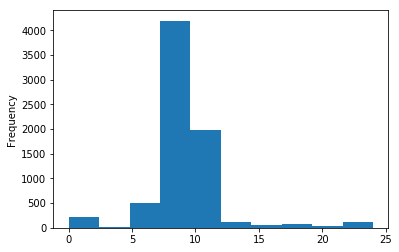

In [487]:
final_place_df.open_times.plot(kind='hist')

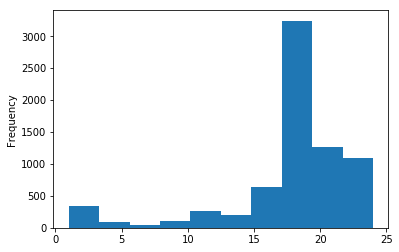

In [488]:
final_place_df.close_times.plot(kind='hist')

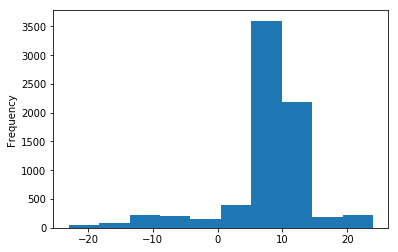

In [491]:
final_place_df.num_hours_opening.plot(kind='hist')

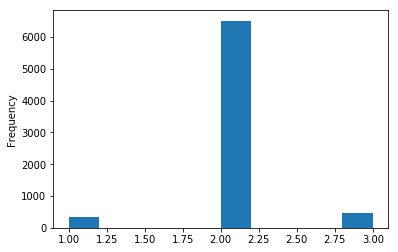

In [489]:
final_place_df.price_size.plot(kind='hist')

In [492]:
final_user_df.describe()

,open_times,close_times,num_days,price_size,num_hours_opening
count,2287.000000,2287.000000,2287.0,2287.000000,2287.000000
mean,9.953349,16.440953,7.0,2.039904,6.487604
std,3.101200,5.155286,0.0,0.393921,7.084057
min,0.000000,1.000000,7.0,1.000000,-22.714286
25%,9.142857,14.357143,7.0,2.000000,4.000000
50%,9.750000,17.355601,7.0,2.057252,7.869528
75%,11.000000,19.838900,7.0,2.057252,10.183096
max,24.000000,24.000000,7.0,3.000000,24.000000


# Extract Features

In [493]:
mean_rate= valid_review_df_dropped.rating.mean()
avg_place_feat = list(final_place_df.mean().values)
avg_user_feat = list(final_user_df.mean().values)
def feature(row):
    #print(1)
    # constant feature for wx+b
    u = row.iloc[0]
    p = row.iloc[1]
    datum = [1]
    # user data
    #print(4)
    if u in final_user_df.index:
        u_d = list(final_user_df.loc[u].values)
    else:
        u_d = avg_user_feat
    #print(3)
    #place data
    if p in final_place_df.index:
        p_d = list(final_place_df.loc[p].values)
    else:
        p_d = avg_place_feat
    # combined data
    cd = []
    cd += [u_d[0]-p_d[0]]
    cd += [u_d[1]-p_d[1]]
    cd += [u_d[3]-p_d[3]]
    cd += [u_d[4]-p_d[5]]
    cats = []
    if p in place_dict:
        cats = place_dict[p]
    total = []
    #print(2)
    if u in user_rating_cat:
        for c in cats:
            total += user_rating_cat[u][c]
        if len(total)>0:
            avg = np.mean(total)
        else:
            concat = np.concatenate(list(user_rating_cat[u].values()))
            if len(concat):
                avg = np.mean(concat)
            else:
                avg = mean_rate
    else:
        avg = mean_rate
#     print(datum)
#     print(u_d)
#     print(cd)
#     print(p_d)
    datum = datum + u_d + p_d +cd+[avg]
    return datum

In [440]:
Original_X = valid_review_df_dropped[['gPlusUserId','gPlusPlaceId']]
Y = valid_review_df_dropped.rating
Original_X.head()

,gPlusUserId,gPlusPlaceId
213,110090296112763745586,107762553597304912662
234,102172401918858106420,111280162645644452653
305,113939131914163721697,105539817238070523193
508,109529024903466465111,103566537416444715680
669,104960884941951050236,105361852687606942835


In [439]:
X = Original_X.apply(feature,axis=1)

# Train Model and Predict

In [451]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [456]:
X_train, X_test, y_train, y_test = train_test_split(list(X), list(Y), test_size=0.1)

In [459]:
clf = SVR()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
# clf.score(X_test, y_test)
sum((predictions - y_test)**2) / len(y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.27126172033829243

### The Mean Squared Error here we got from the linear SVR regression is 0.27126, which is a big jump from our baseline model (MSE = 0.826)